# Visualize patch and experiments

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader


device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print("device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize the images
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=1, shuffle=False
)



device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [5]:
data_mean_np = np.array([0.4914, 0.4822, 0.4465])
data_std_np = np.array([0.2023, 0.1994, 0.2010])

## Visualize prediction

c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


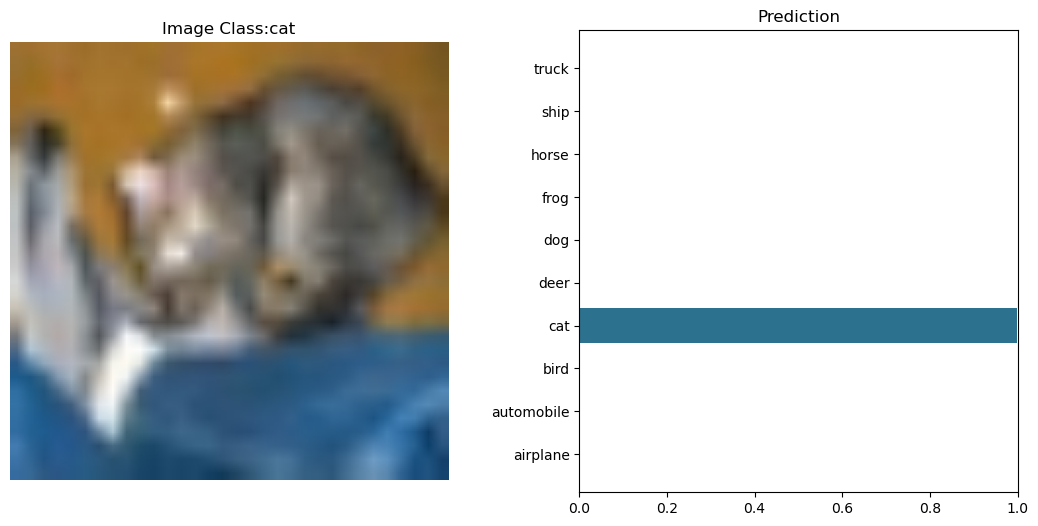

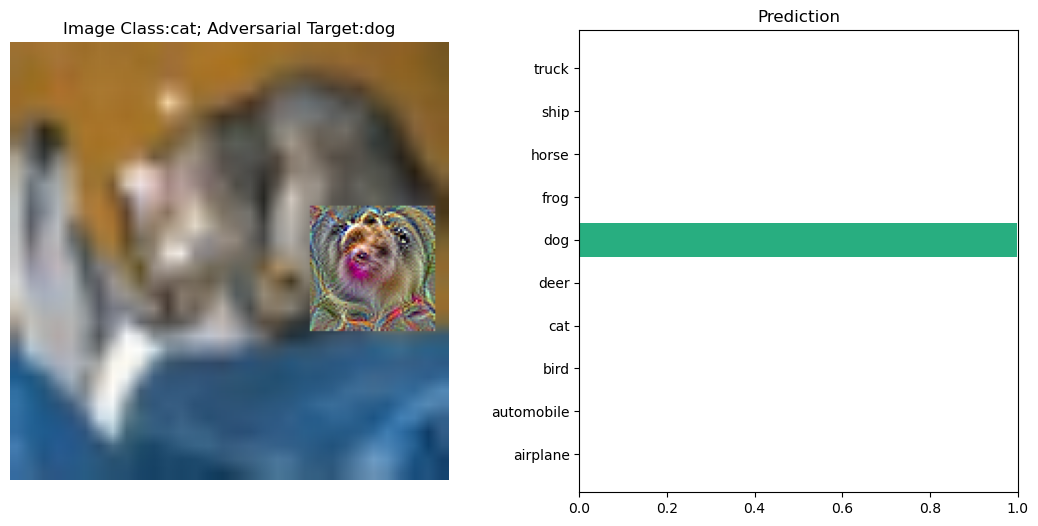

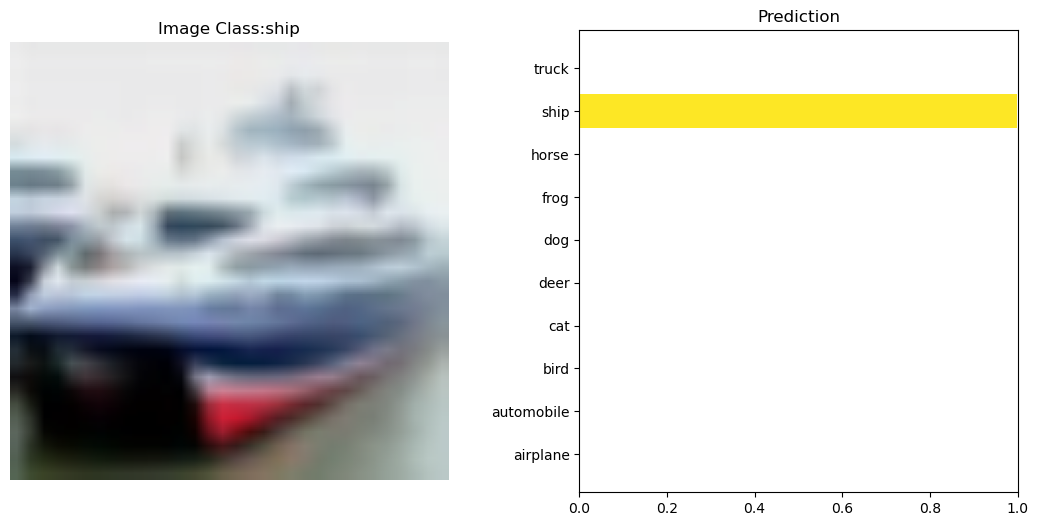

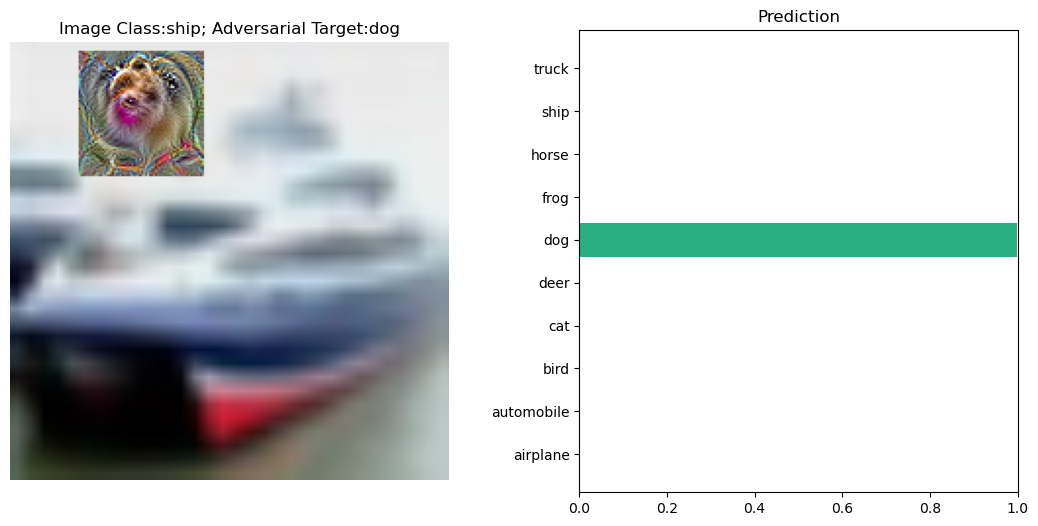

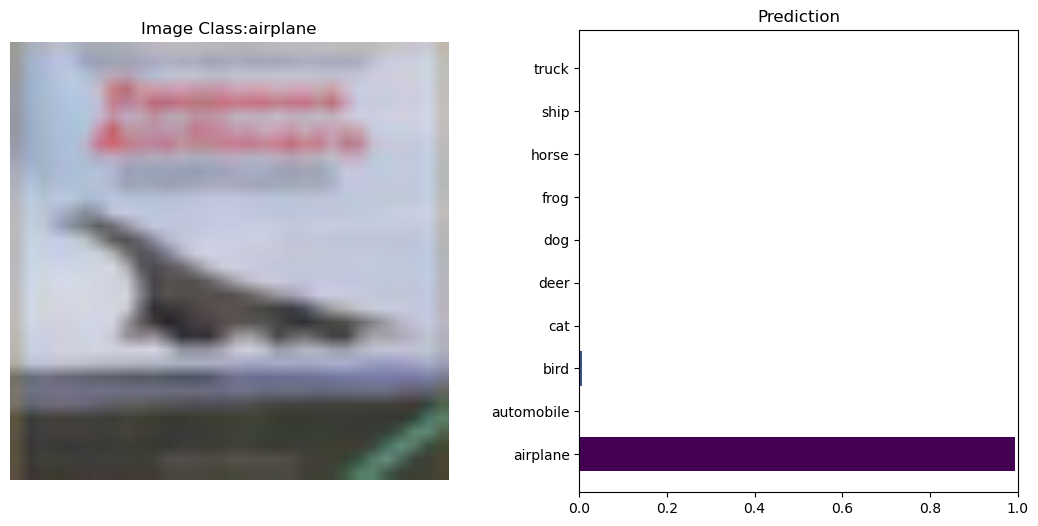

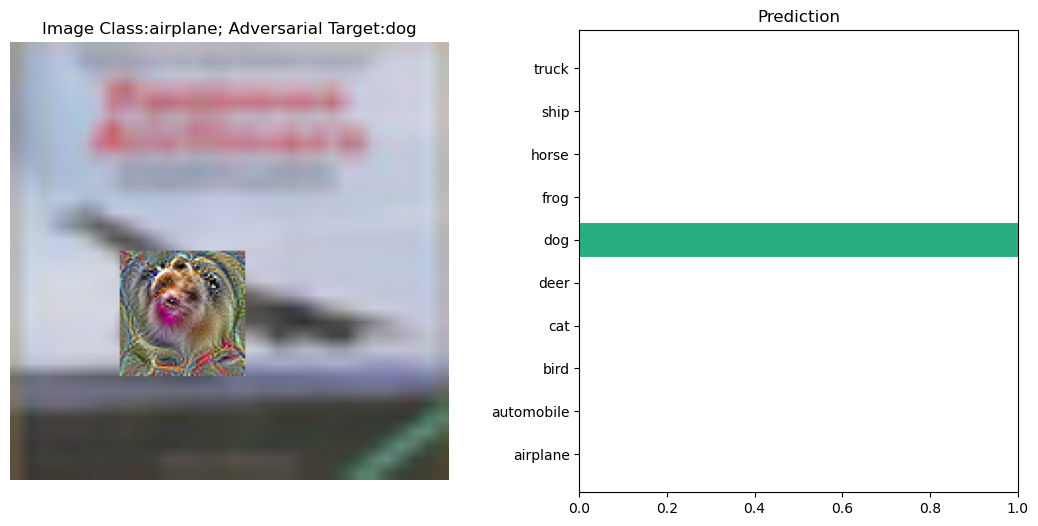

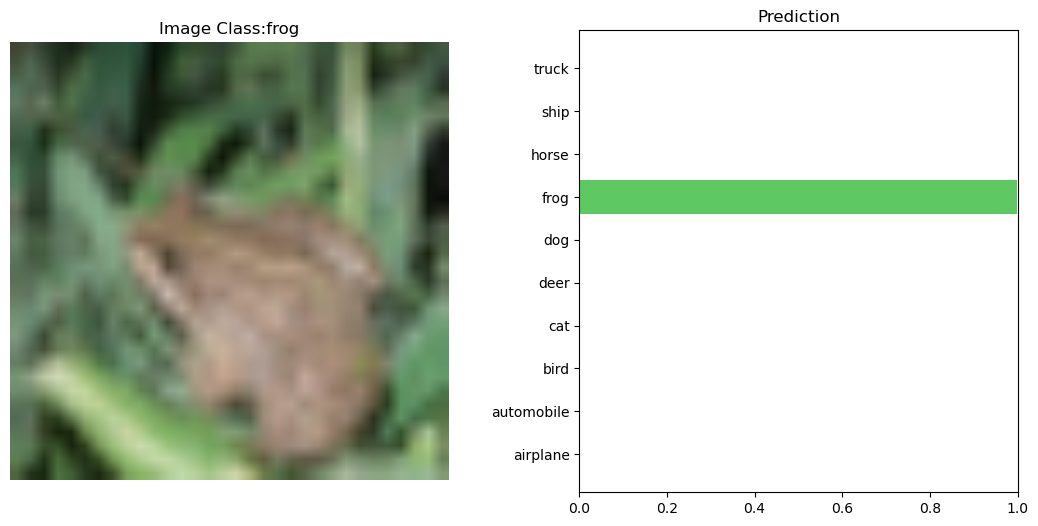

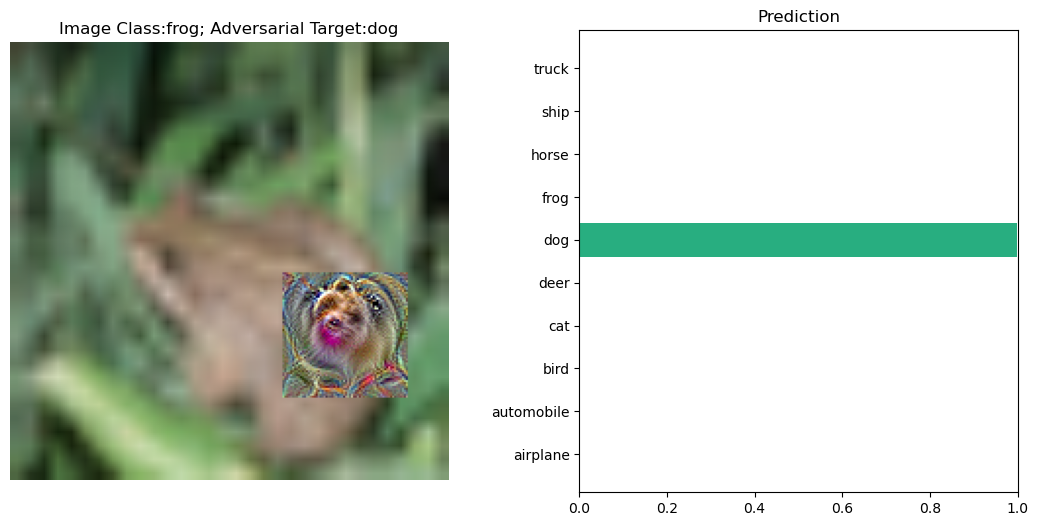

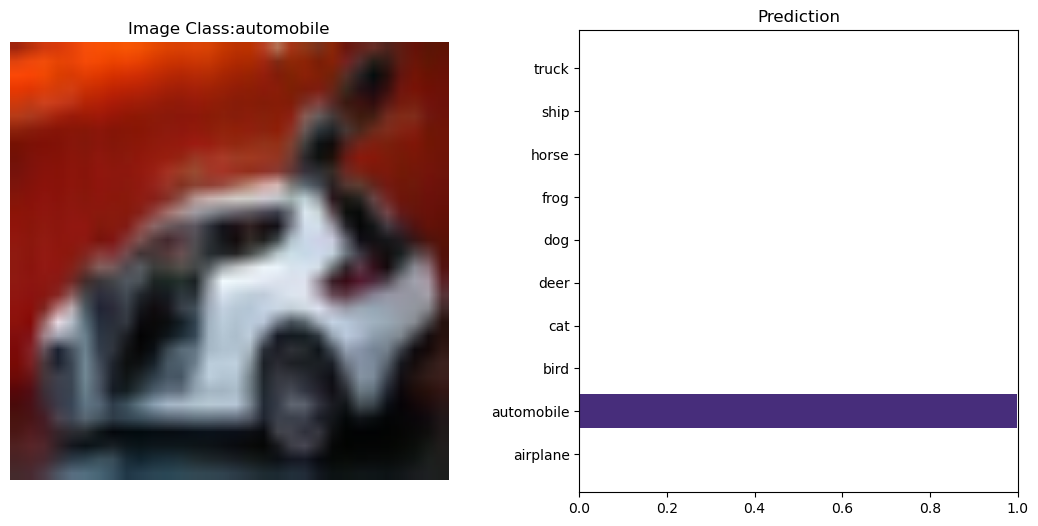

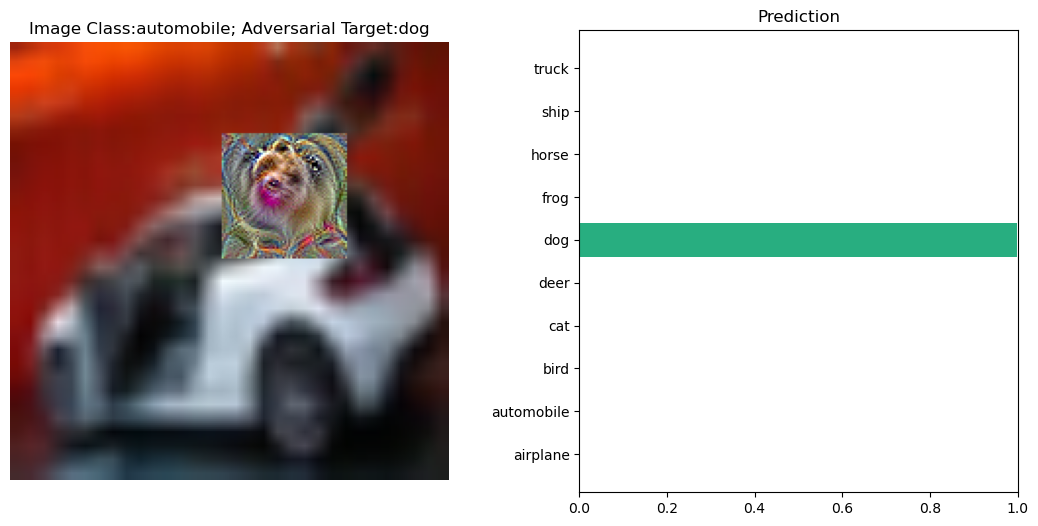

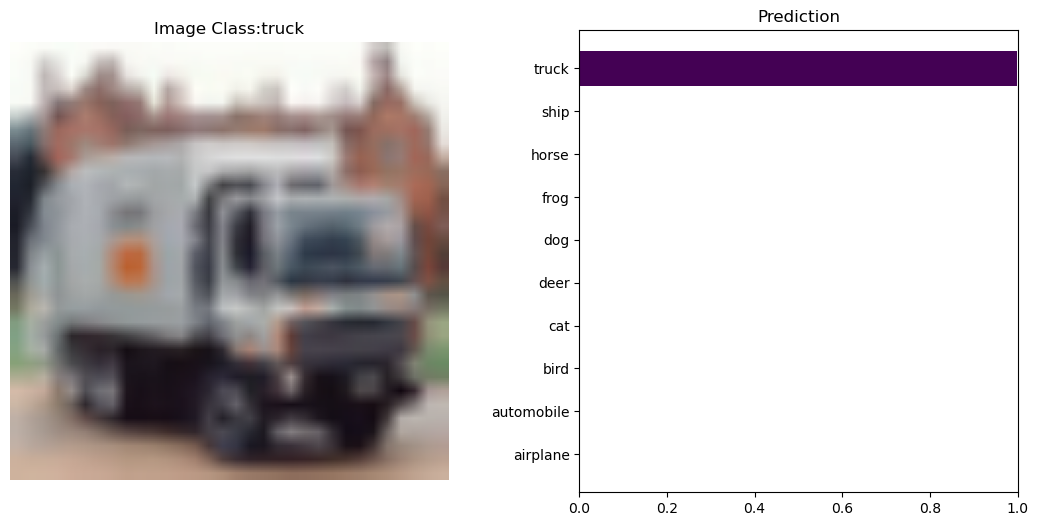

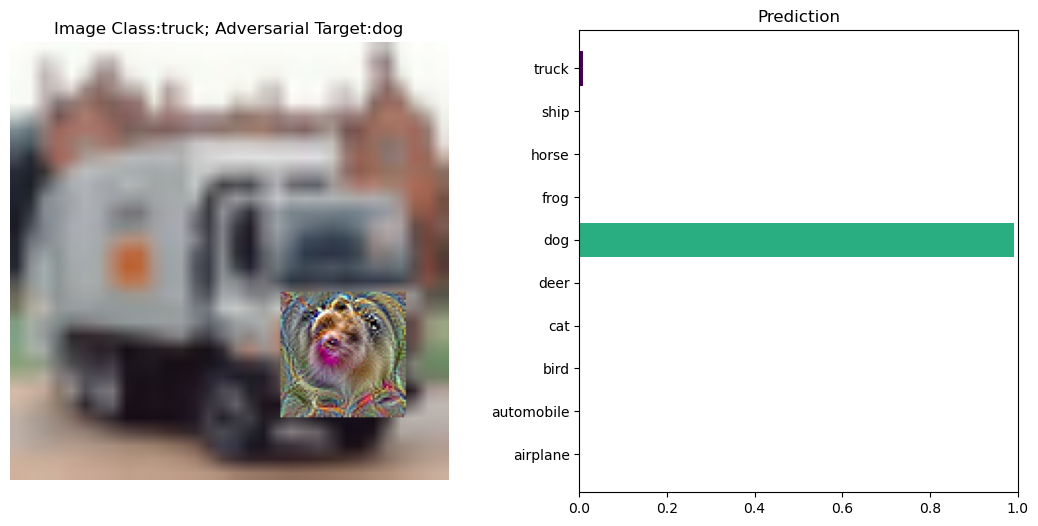

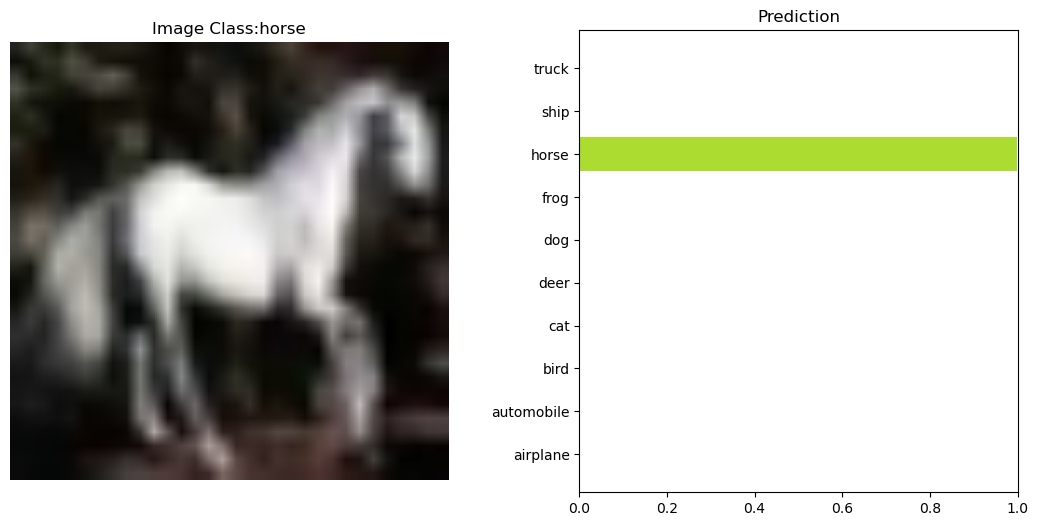

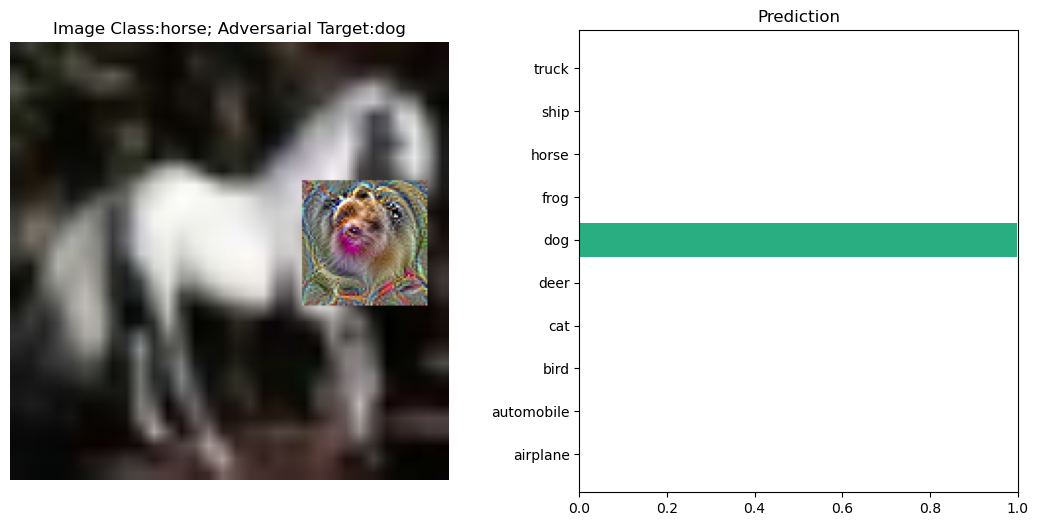

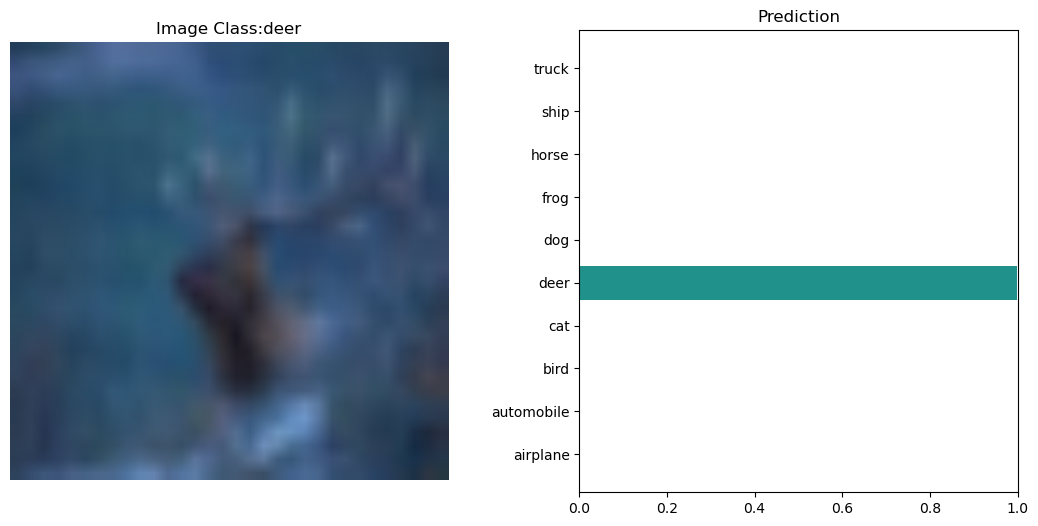

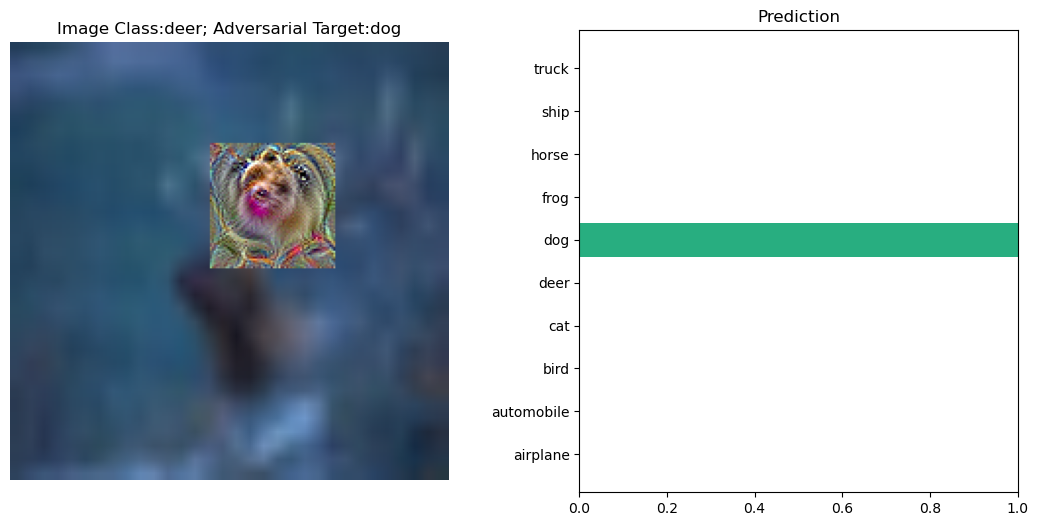

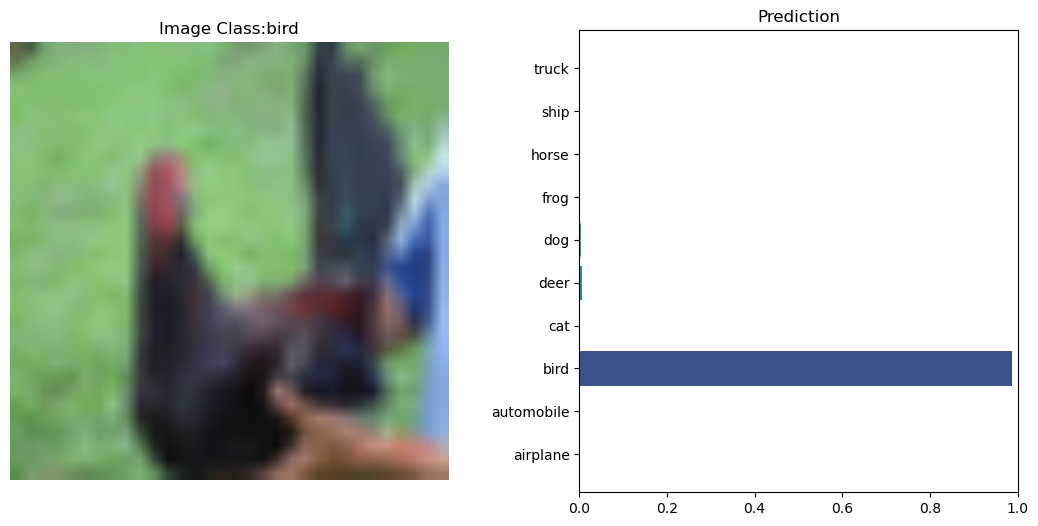

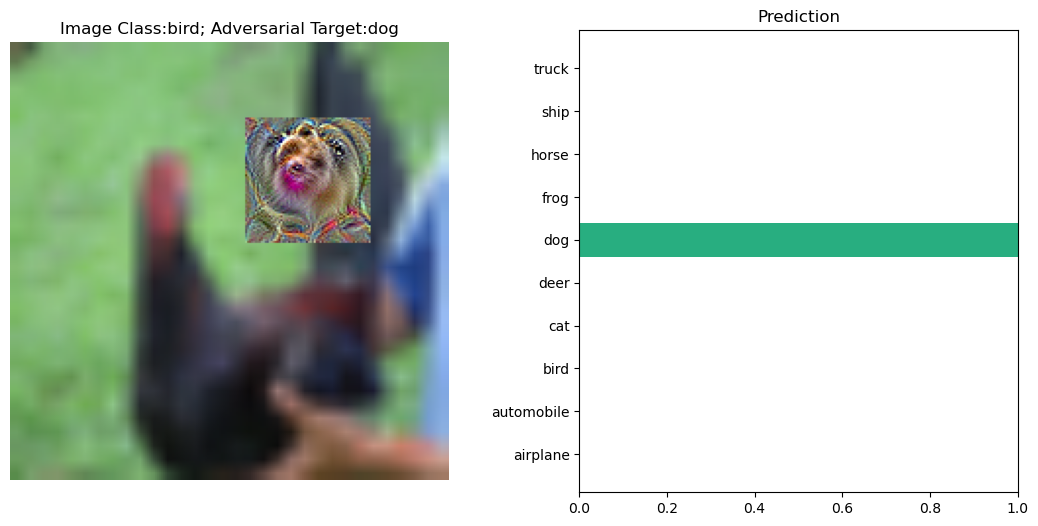

In [88]:
import matplotlib.cm as cm
import os
from torchvision import models
from util import apply_patch

img_classes = []

# Classes in CIFAR10 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

# Load the patch
target_text = 'dog'
target_class = torch.tensor([train_dataset.classes.index(target_text)]).to(device)
patch_size = 64
final_patch_tensor = torch.from_numpy(np.load(f'patches/adv_patch_{target_text}_{patch_size}.npy')).to(device)

# Load image classifier
num_classes = 10  # Number of classes in CIFAR-10

# ResNet-50 model
model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
model = model.to(device)
model.load_state_dict(torch.load(os.path.join("./saved_model", 'resnet50_.pth'))['state_dict']) 

# VGG16
# model = models.vgg16(pretrained = True)
# model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join("./saved_model", 'vgg16_.pth'))['state_dict']) 


# DenseNet model
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join("./saved_model", 'densenet_.pth'))['state_dict']) 

model.eval()

for i, (img, target) in enumerate(test_loader): 
    if (target.item() not in img_classes) and (target != train_dataset.classes.index(target_text)):
        img_classes.append(target)
        # Move data to gpu
        img = img.to(device)
        target = target.to(device)
        with torch.no_grad():
            # Get prediction of unpatched image
            img_clean = img.clone()
            img_clean= img_clean.to(device)
            out = model(img_clean)
            _, pred_class_clean = out.max(1)

            # Visualize prediction
            # Plot original image and prediction
            plt.figure(figsize=(13, 6))

            # Plot original image
            plt.subplot(1, 2, 1)
            plt.imshow(np.clip(np.transpose(img.detach().cpu().numpy().squeeze(0), (1, 2, 0))*data_std_np + data_mean_np, 0, 1))
            plt.title(f"Image Class:{train_dataset.classes[target.item()]}")
            plt.axis('off')

            # Plot prediction
            plt.subplot(1, 2, 2)
            colors = cm.viridis(np.linspace(0, 1, 9))
            plt.barh(train_dataset.classes, torch.softmax(out, dim=-1).detach().cpu().numpy().squeeze(0), color=colors)
            plt.xlim([0, 1])
            plt.title("Prediction")
            plt.subplots_adjust(wspace=0.3)
            plt.savefig(f'experiment_img/clean_{train_dataset.classes[target.item()]}.png', bbox_inches='tight', dpi=300)
            plt.show()
            
            # Only apply patches on images that not in target class
            # Skip images that are predicted incorrectly into target class
            if target != target_class and pred_class_clean != target_class:
                # Get patched prediction
                patched_img = img.clone()
                location = (random.randint(0, patched_img.shape[2] - patch_size), random.randint(0, patched_img.shape[3] - patch_size))
                patched_img = apply_patch(patched_img, final_patch_tensor, patch_size, location).to(device)
                out_patched = model(patched_img)
                
                # Plot patched image and prediction
                plt.figure(figsize=(13, 6))

                # Plot original image
                plt.subplot(1, 2, 1)
                plt.imshow(np.clip(np.transpose(patched_img.detach().cpu().numpy().squeeze(0), (1, 2, 0))*data_std_np + data_mean_np, 0, 1))
                plt.title(f"Image Class:{train_dataset.classes[target.item()]}; Adversarial Target:{train_dataset.classes[target_class.item()]}")
                plt.axis('off')

                # Plot prediction
                plt.subplot(1, 2, 2)
                plt.barh(train_dataset.classes, torch.softmax(out_patched, dim=-1).detach().cpu().numpy().squeeze(0), color=colors)
                plt.xlim([0, 1])
                plt.title("Prediction")
                plt.subplots_adjust(wspace=0.3)
                plt.savefig(f'experiment_img/adv_{train_dataset.classes[target.item()]}_with_{train_dataset.classes[target_class.item()]}.png', bbox_inches='tight', dpi=300)
                plt.show()
                
    elif len(img_classes)==9:
        break
    else:
        pass

## Visualize all patches

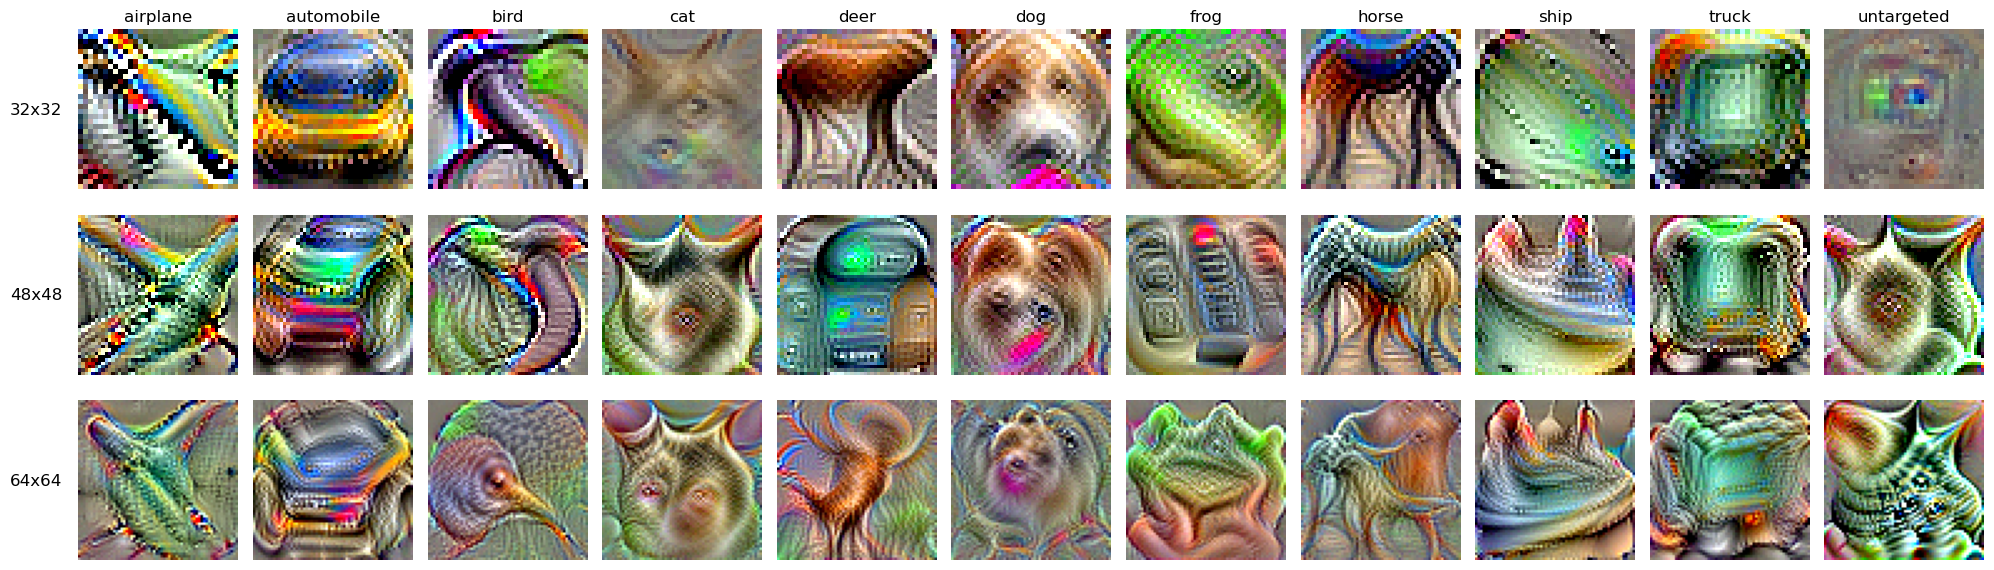

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(3, 11, figsize=(20, 6))

for i, target_text in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'untargeted']):
    for j, patch_size in enumerate([32, 48, 64]):
        patch_np =np.load(f'patches/adv_patch_{target_text}_{patch_size}.npy')
        img = np.transpose(np.clip(patch_np * data_std_np[:, None, None] + data_mean_np[:, None, None], 0, 1), (1, 2, 0))
        ax = axes[j, i]
        ax.imshow(img)
        if j ==0:
            ax.set_title(f'{target_text}')
        ax.axis('off')
        if i == 0:
            ax.text(-0.1, 0.5, f'{patch_size}x{patch_size}', transform=ax.transAxes, 
                    horizontalalignment='right', verticalalignment='center', 
                    fontsize=12, color='black')
plt.tight_layout()
plt.show()


## Visualize ASR

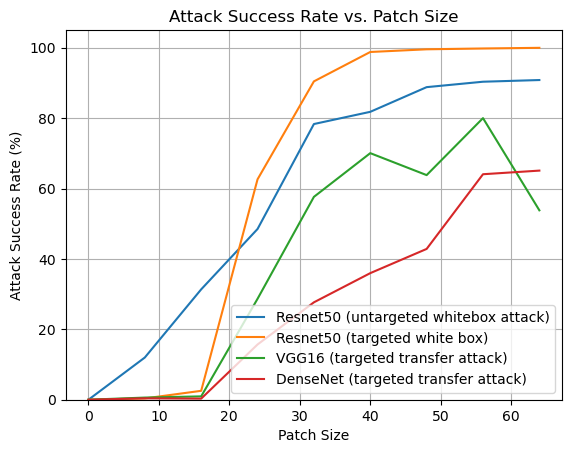

In [ ]:
# Define the data
model_names = ["Resnet50 (untargeted whitebox attack)", "Resnet50 (targeted white box)", "VGG16 (targeted transfer attack)", "DenseNet (targeted transfer attack)"]
patch_sizes = [0, 8, 16, 24, 32, 40, 48, 56, 64]

# ASR data for each model and patch size
asr_data = {
    "Resnet50 (untargeted whitebox attack)": [0, 11.99, 31.35, 48.50, 78.32, 81.79, 88.80, 90.34, 90.82],
    "Resnet50 (targeted white box)": [0, 0.37, 2.53, 62.61, 90.44, 98.79, 99.55, 99.78, 99.97],
    "VGG16 (targeted transfer attack)": [0, 0.61, 0.95, 28.67, 57.63, 70.05, 63.81, 80.00, 53.81],
    "DenseNet (targeted transfer attack)": [0, 0.40, 0.31, 15.69, 27.67, 35.96, 42.84, 64.06, 65.09],
}

# Plot ASR vs. Patch Size for each model
for model in model_names:
    asr_values = asr_data[model]
    plt.plot(patch_sizes, asr_values, label=model)

# Customize the plot
plt.xlabel('Patch Size')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs. Patch Size')
plt.ylim([0, 105])
plt.legend()

# Show the plot
plt.grid()
plt.show()


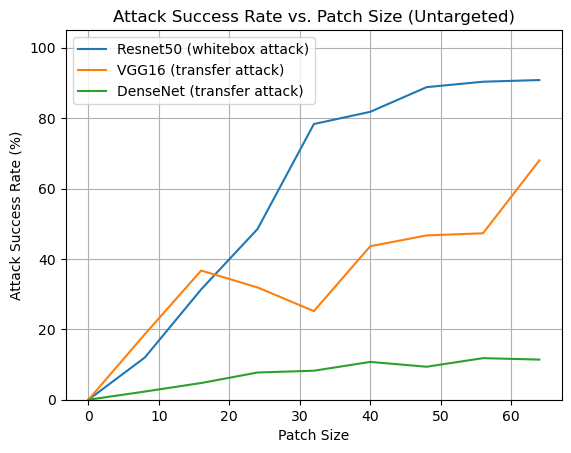

In [ ]:
# Define the data
model_names = ["Resnet50 (whitebox attack)", "VGG16 (transfer attack)", "DenseNet (transfer attack)"]
patch_sizes = [0, 8, 16, 24, 32, 40, 48, 56, 64]

# ASR data for each model and patch size
asr_data = {
    "Resnet50 (whitebox attack)": [0, 11.99, 31.35, 48.50, 78.32, 81.79, 88.80, 90.34, 90.82],
    "VGG16 (transfer attack)": [0, 18.60, 36.70, 31.90, 25.17, 43.61, 46.68, 47.28,  67.99],
    "DenseNet (transfer attack)": [0, 2.32, 4.75, 7.73, 8.24, 10.74, 9.37, 11.81, 11.40],
}

# Plot ASR vs. Patch Size for each model
for model in model_names:
    asr_values = asr_data[model]
    plt.plot(patch_sizes, asr_values, label=model)

# Customize the plot
plt.xlabel('Patch Size')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs. Patch Size (Untargeted)')
plt.ylim([0, 105])
plt.legend()

# Show the plot
plt.grid()
plt.show()